In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11979344678235941735
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6807266214533919712
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1528209143064902617
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10048402226672558481
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Building the training dataset.
Let's look at the train image list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/dataset/train/"
file_list = os.listdir(path)
file_list[:20]

['6_113_mask.tif',
 '6_2.tif',
 '5_91_mask.tif',
 '6_33.tif',
 '6_14.tif',
 '5_83_mask.tif',
 '6_108.tif',
 '5_82.tif',
 '6_35.tif',
 '6_118_mask.tif',
 '6_32_mask.tif',
 '6_24.tif',
 '6_115.tif',
 '6_23_mask.tif',
 '5_86_mask.tif',
 '6_110.tif',
 '5_77.tif',
 '6_28_mask.tif',
 '5_9.tif',
 '6_23.tif']

**Sort the file list in ascending order and seperate it into images and masks**<br/>
Each file has the form of either "subject_imageNum.tif" or "subject_imageNum_mask.tif", so we can extract `subject` and `imageNum` from each file name by using regular expression. `"[0-9]+"` means to find the first consecutive number.<br/>

In [ ]:
train_image = []
train_mask = glob(path + '*_mask*')

for i in train_mask:
    train_image.append(i.replace('_mask', ''))
        
print(train_image[:10],"\n" ,train_mask[:10])

['/content/drive/MyDrive/dataset/train/6_113.tif', '/content/drive/MyDrive/dataset/train/5_91.tif', '/content/drive/MyDrive/dataset/train/5_83.tif', '/content/drive/MyDrive/dataset/train/6_118.tif', '/content/drive/MyDrive/dataset/train/6_32.tif', '/content/drive/MyDrive/dataset/train/6_23.tif', '/content/drive/MyDrive/dataset/train/5_86.tif', '/content/drive/MyDrive/dataset/train/6_28.tif', '/content/drive/MyDrive/dataset/train/5_84.tif', '/content/drive/MyDrive/dataset/train/6_13.tif'] 
 ['/content/drive/MyDrive/dataset/train/6_113_mask.tif', '/content/drive/MyDrive/dataset/train/5_91_mask.tif', '/content/drive/MyDrive/dataset/train/5_83_mask.tif', '/content/drive/MyDrive/dataset/train/6_118_mask.tif', '/content/drive/MyDrive/dataset/train/6_32_mask.tif', '/content/drive/MyDrive/dataset/train/6_23_mask.tif', '/content/drive/MyDrive/dataset/train/5_86_mask.tif', '/content/drive/MyDrive/dataset/train/6_28_mask.tif', '/content/drive/MyDrive/dataset/train/5_84_mask.tif', '/content/drive/

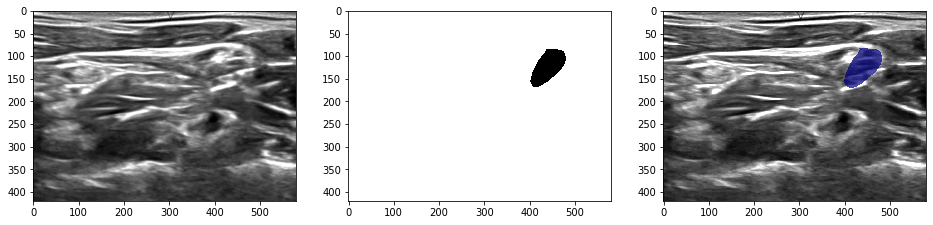

In [ ]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

Now, I try to load all image files and store them variables X and y. Afther doing this, I recognize that it takes very much memory.<br/>
Please let me know if there are several efficient ways to store image file

In [ ]:
width = 128
height = 128

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from sklearn import metrics

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *

def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)

    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, res, out_channels, depth):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # UpConvolutional layer
    db = UpSampling2D((2, 2), interpolation='bilinear')(inputs)
    db = concatenate([db, res], axis=3)
    # First conv2D layer 
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    if depth > 2:
        # Third conv2D layer
        db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

def TransCGUNet(input_size=(512, 512, 1)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)

    # VGG16 with imagenet weights
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_size)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inputs)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    
    # Second encoder block
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    
    # Third encoder block
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)
    center = MaxPooling2D(pool_size=(2, 2))(enc3)

    # Center block
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    
    # classification branch
    cls = Conv2D(32, (3,3), activation='relu', padding='same')(center)
    # cls = Conv2D(128, (3,3), activation='relu', padding='same')(center)
    cls = Conv2D(1, (1,1))(cls)
    cls = GlobalAveragePooling2D()(cls)
    cls = Activation('sigmoid', name='class')(cls)
    clsr = Reshape((1, 1, 1), name='reshape')(cls)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = decoder_block(center, res_path3, 256, 3)
    
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = decoder_block(dec3, res_path2, 128, 2)
    
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = decoder_block(dec2, res_path1, 64, 1)

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid')(out)
    out = multiply(inputs=[out,clsr], name='seg')
    
    # Final model
    model = Model(inputs=[inputs], outputs=[out, cls])
    
    return model

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def train_generator(data_frame, batch_size, train_path, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask, label = adjust_data(img, mask)
        yield (img,[mask,label])

def adjust_data(img,mask):
    img = preprocess_input(img)
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    masks_sum = np.sum(mask, axis=(1,2,3)).reshape((-1, 1))
    class_lab = (masks_sum != 0) + 0.
    
    return (img, mask, class_lab)

In [ ]:
pos_mask = []
pos_img = []
neg_mask = []
neg_img = []

for mask_path, img_path in zip(train_mask, train_image):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if np.sum(mask) == 0:
        neg_mask.append(mask_path)
        neg_img.append(img_path)
    else:
        pos_mask.append(mask_path)
        pos_img.append(img_path)

In [ ]:
!mkdir generated
!mkdir generated/img

In [ ]:
def flip_up_down(img):
    newImg = img.copy()
    return cv2.flip(newImg, 0)

def flip_right_left(img):
    newImg = img.copy()
    return cv2.flip(newImg, 1)

In [ ]:
gen_img = []
gen_mask = []

for (img_path, mask_path) in tqdm(zip(pos_img, pos_mask)):
    image_name = img_path.split('/')[-1].split('.')[0]

    uf_img_path = 'generated/img/'+image_name+'_uf.jpg'
    uf_mask_path = 'generated/img/'+image_name+'_uf_mask.jpg'
    rf_img_path = 'generated/img/'+image_name+'_rf.jpg'
    rf_mask_path = 'generated/img/'+image_name+'_rf_mask.jpg'

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    uf_img = flip_up_down(img)
    uf_mask = flip_up_down(mask)
    rf_img = flip_right_left(img)
    rf_mask = flip_right_left(mask)

    cv2.imwrite(uf_img_path, uf_img)
    cv2.imwrite(uf_mask_path, uf_mask)
    cv2.imwrite(rf_img_path, rf_img)
    cv2.imwrite(rf_mask_path, rf_mask)
    
    gen_img.append(uf_img_path)
    gen_mask.append(uf_mask_path)
    gen_img.append(rf_img_path)
    gen_mask.append(rf_mask_path)

948it [09:15,  1.74it/s]

KeyboardInterrupt: ignored

In [ ]:
aug_img = gen_img + train_image
aug_mask = gen_mask + train_mask

df_ = pd.DataFrame(data={"filename": aug_img, 'mask' : aug_mask})
df = df_.sample(frac=1).reset_index(drop=True)

# df = df[0:160]

kf = KFold(n_splits = 5, shuffle=False)

In [ ]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

EPOCHS = 100
BATCH_SIZE = 32

for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = TransCGUNet(input_size=(height,width, 3))
    model.compile(optimizer=Adam(lr=5e-6), loss={'seg':dice_coef_loss, 'class':'binary_crossentropy'}, \
                      loss_weights={'seg':1, 'class':1}, metrics={'seg':[iou, dice_coef, sensitivity, specificity,'binary_accuracy'], 'class':['accuracy']})

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)

    history = model.fit(train_gen,
                          steps_per_epoch=len(train_data_frame) // BATCH_SIZE, 
                          epochs=EPOCHS, 
                          callbacks=[model_checkpoint],
                          validation_data = test_gener,
                          validation_steps=len(test_data_frame) // BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'sensitivity': sensitivity, 'specificity': specificity})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['seg_binary_accuracy'])
    losses.append(results['seg_loss'])
    dicecoefs.append(results['seg_dice_coef'])
    ious.append(results['seg_iou'])
    
    break

In [ ]:
import cv2
from sklearn import metrics

test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
pred = model.predict(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
pred = np.sum(pred[0], axis=(1,2,3))      # onno model e pred[0] er jaygay pred hobe
pred[pred>0] = 1

true = []
for i in test_data_frame['mask']:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    s = np.sum(img)
    if s > 0:
        true.append(1)
    else:
        true.append(0)

true = np.array(true)

cm = metrics.confusion_matrix(true, pred)

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))    
# calculate the specificity
conf_specificity = (TN / float(TN + FP))

print('Sensitivity', conf_sensitivity)
print('Specificity', conf_specificity)

In [ ]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
        
    with open(str(h+1) + '_ultrasound_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
print('accuracies : ', np.array(accuracies))
print('losses : ', np.array(losses))
print('ious : ', np.array(ious))
print('dicecoefs : ', np.array(dicecoefs))

print('\naverage accuracy : ', np.mean(np.array(accuracies)), '+-', np.std(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)), '+-', np.std(np.array(losses)))
print('average iou : ', np.mean(np.array(ious)), '+-', np.std(np.array(ious)))
print('average dice_coe : ', np.mean(np.array(dicecoefs)), '+-', np.std(np.array(dicecoefs)))

In [ ]:
selector = np.argmin(abs(np.array(ious) - np.mean(ious)))
model = load_model(str(selector+1)+'_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
for i in range(20):
    index=np.random.randint(0,len(test_data_frame.index))
    print(i+1, index)
    img = cv2.imread(test_data_frame['filename'].iloc[index])
    img = cv2.resize(img, (height, width))
    img = img[np.newaxis, :, :, :]
    img = preprocess_input(img)
    pred = model.predict(img)
    print('Class Prediction : ',pred[1])

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(cv2.resize(cv2.imread(test_data_frame['filename'].iloc[index]), (height, width)))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index]), (height, width))))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred[0]) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
!rm -r generated